## Text2Image
We load the pretrained LoRA checkpoint and give it a quick try based on txt2img pipeline.

In [1]:
from IPython.core.debugger import Pdb
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import DPMSolverMultistepScheduler as scheduler
from diffusers.utils import load_image
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_ID = 'runwayml/stable-diffusion-v1-5'
USE_CUSTOM_VAE = False
USE_IP_ADAPTER = True


if USE_CUSTOM_VAE:
    # Load custom vae for better reconstructing face
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        vae=AutoencoderKL.from_pretrained('../downloads/vae-ft-mse-840000-ema-pruned/', use_safetensors=True),
        scheduler=scheduler.from_pretrained(MODEL_ID, subfolder='scheduler', use_safetensors=True),
        safety_checker=None,
        use_safetensors=True,
    )
else:
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        scheduler=scheduler.from_pretrained(MODEL_ID, subfolder='scheduler', torch_dtype=torch.float16, use_safetensors=True),
        safety_checker=None,
        torch_dtype=torch.float16,
        use_safetensors=True,
    )

# Load LoRA or DreamBooth w/LoRA
LORA_PATH = '../models/finetune/lora/coolmate/1/'
DB_PATH = '../models/finetune/dreambooth_w_lora/coolmate/1/'
pipe.load_lora_weights(
    DB_PATH,
    weight_name='pytorch_lora_weights.safetensors',
)

if USE_IP_ADAPTER:
    # Load IP-Adapter for more granular control with image prompt
    pipe.load_ip_adapter('h94/IP-Adapter', subfolder="models", weight_name="ip-adapter_sd15.bin")
    pipe.set_ip_adapter_scale(1.0)

pipe.to(device)

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
prompt1 = 'a young men wearing black t-shirt, best quality, 4k, 8k, ultra highres, standing full body \
raw photo in hdr, sharp focus, intricate texture, skin imperfections, detailed eyes, glossy eyes'

prompt2 = 'a photo of sks black polo neck t-shirt'

negative_prompt = '3d, cartoon, anime, sketches, (worst quality, bad quality, cropped:1.4) ((monochrome) ), \
((grayscale) ), (bad-hands-5:1) , (badhandv4) , (easynegative:0.8) , (bad-artist-anime:) , (bad-artist:) , (bad_prompt:) , \
(bad-picture-chill-75v:) , (bad_prompt_version2:) , (bad_quality:) , Asian-Less-Neg bad-hands-5 bad_pictures \
bad artist -neg CyberRealistic_Negative-neg negative_hand-neg ng_deepnegative_v1_75t, verybadimagenegative_v1. 3, lowres, \
low quality, jpeg, artifacts, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, \
poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, \
gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, \
drawing, painting, crayon, sketch, graphite, impressionist, noisy, soft'

lora_scale = 0.9
num_inference_steps = 50
seed = torch.manual_seed(1337)

if USE_IP_ADAPTER:
    image = pipe(
        prompt=prompt2,
        ip_adapter_image=load_image('../dataset/db/coolmate/1/img1.jpg'),
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        cross_attention_kwargs={'scale': lora_scale},
        generator=seed
    ).images[0]
else:
    image = pipe(
        prompt=prompt2,
        negative_prompt=negative_prompt,
        num_inference_steps=num_inference_steps,
        cross_attention_kwargs={'scale': lora_scale},
        generator=seed
    ).images[0]

100%|██████████| 50/50 [00:02<00:00, 16.90it/s]


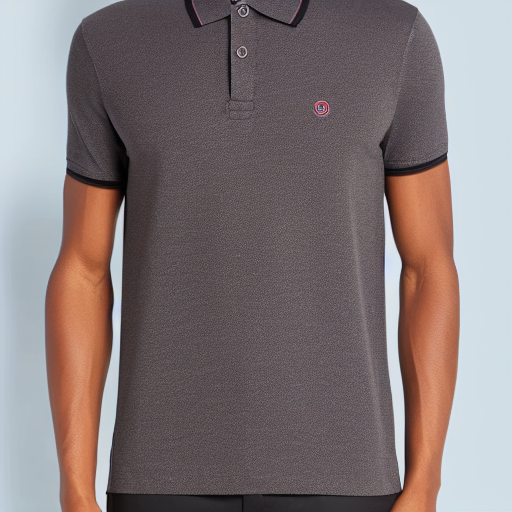

In [11]:
image

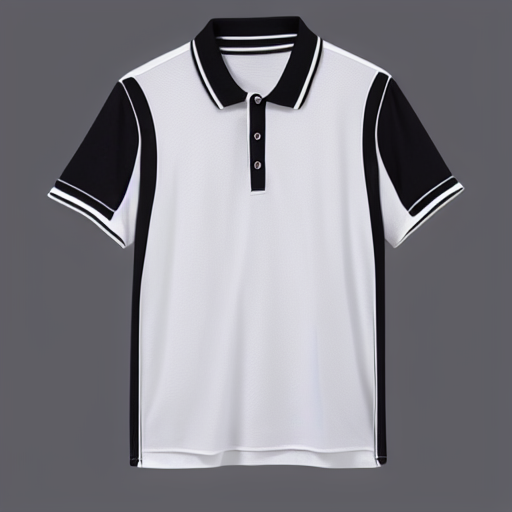

In [5]:
image

## Inpainting